<a href="https://colab.research.google.com/github/rewerc/tensorflow-workspace/blob/main/skimlit_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0b79a99b-9cc2-2b72-b0f4-2446a27b7caf)


## Get data  

Data: PubMed-RCT

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_200k_RCT

dev.txt  test.txt  train.7z


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
with open("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt", "r") as file:
  for i in file.readlines()[0:30]:
    print(i, end="")

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

In [ ]:
# 20k datasets, numbers replaced with "@"
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
data_dir

'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
def get_lines(filename):
  with open(filenames[1], "r") as f:
    return f.readlines()

In [ ]:
text_lines = get_lines(filenames[1])
text_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
def preprocess_text(list_of_lines):
  preprocessed = []
  cur = 0
  total_lines = 0
  for i, line in enumerate(list_of_lines):
    if "###" == line[:3]:
      cur = 0
      total_lines = 0
      for j in list_of_lines[i+1:]:
        if j == "\n":
          break
        total_lines += 1
      continue

    if "\t" in line:
      target, text = line.split("\t")
      preprocessed.append({
          "line_number": cur,
          "target": target,
          "text": text.lower(),
          "total_lines": total_lines
      })
    cur += 1
      
  return preprocessed

In [ ]:
preprocess_text(text_lines)[:3]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .\n',
  'total_lines': 12},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'total_lines': 12},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'total_lines': 12}]

In [ ]:
test_samples = preprocess_text(get_lines(filenames[0]))
train_samples = preprocess_text(get_lines(filenames[1]))
val_samples = preprocess_text(get_lines(filenames[2]))

In [ ]:
len(test_samples), len(train_samples), len(val_samples)

(180040, 180040, 180040)

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12


In [ ]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

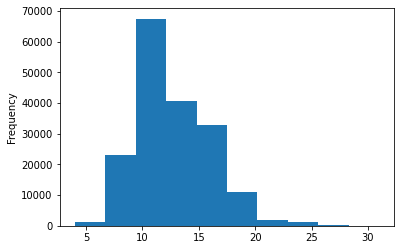

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
train_ohe = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_ohe = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_ohe = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
test_ohe.shape

(180040, 5)

In [ ]:
train_ohe

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
train_sentences = train_df["text"].tolist()
test_sentences = test_df["text"].tolist()
val_sentences = val_df["text"].tolist()
train_sentences

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .\n',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .\n',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .\n',
 'there 

In [ ]:
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
train_enc = label_encoder.fit_transform(train_df["target"].to_numpy())
val_enc = label_encoder.transform(val_df["target"].to_numpy())
test_enc = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
train_enc

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

In [ ]:
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0

Naive-Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_enc)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sentences, y=val_enc)

0.7516829593423684

In [ ]:
y_pred = model_0.predict(val_sentences)
y_pred

array([1, 2, 4, ..., 4, 1, 2])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                               y_pred,
                                                                               average="weighted")
  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

In [ ]:
model_0_results = calculate_results(y_true=val_enc,
                                    y_pred=y_pred)
model_0_results

{'accuracy': 0.7516829593423684,
 'f1': 0.734085177322999,
 'precision': 0.7556121877731266,
 'recall': 0.7516829593423684}

## Model 1
Conv1D

In [ ]:
import numpy as np
from keras import layers
sentence_length = [len(sentence.split()) for sentence in train_sentences]
sentence_length[:10]

[49, 27, 15, 14, 35, 29, 30, 55, 36, 8]

In [ ]:
mean_sentence_length = np.mean(sentence_length)
mean_sentence_length.round()

26.0

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <a list of 30 Patch objects>)

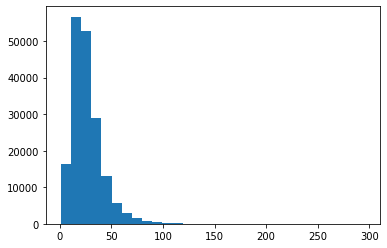

In [ ]:
# distribution of sentence length
plt.hist(sentence_length, bins=30)

In [ ]:
output_length = int(np.percentile(sentence_length, 95))
output_length 

55

In [ ]:
max(sentence_length)

296

Sentence lengths are not balanced. Majority of sentences have under 55 words.
Hence, the safe bet to use is somewhere between 50 and 100. 

In [ ]:
# text vectorizing

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000 # from the PubMed article
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sen = random.choice(train_sentences)

print(f"Text: {target_sen}")
print(f"Length: {len(target_sen)}")
print(f"Vectorized: {text_vectorizer(target_sen)}")

Text: consenting patients with sz receive routine clinical treatment and are randomised to adjunctive yt , adjunctive physical exercise ( pe ) or treatment as usual ( proposed n = @ total , n = @ in each group ) .

Length: 208
Vectorized: [ 4547    12     7 14396   175   633    47    19     3    58   210     6
  2216 16320  2216   189   177  2559    16    19    25   370  1820    40
    76    40     5   122    13     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [ ]:
vocabs = text_vectorizer.get_vocabulary()
vocabs[:10], vocabs[-10:]

(['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were'],
 ['aarm',
  'aaqol',
  'aaq',
  'aanhui',
  'aana',
  'aainduced',
  'aaigroup',
  'aachener',
  'aachen',
  'aaacp'])

In [ ]:
len(vocabs)

64841

In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [ ]:
# Embedding
token_embedding = layers.Embedding(input_dim=len(vocabs),
                                   output_dim=128,
                                   mask_zero=True,
                                   name="embedding_layer")
token_embedding

In [ ]:
target_sen = random.choice(train_sentences)

print(f"Text: {target_sen}")
print(f"Length: {len(target_sen)}")
print(f"Vectorized: {text_vectorizer(target_sen)}")
print(f"Embedded: {token_embedding(text_vectorizer(target_sen))}")

Text: the primary end points in the scandinavian prostate cancer group study number @ ( spcg-@ ) were death from any cause , death from prostate cancer , and the risk of metastases .

Length: 177
Vectorized: [    2    56   199   302     5     2 12986   592   135    13    17   154
 34243     9   339    27   262   887   339    27   592   135     3     2
    73     4  1792     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
Embedded: [[ 0.04662364 -0.04664527  0.01554099 ...  0.01857427  0.02178616
  -0.01315444]
 [-0.04962857  0.01271412 -0.03675865 ...  0.02547877  0.00071285
   0.00019885]
 [ 0.02895233  0.03053934  0.01250508 ...  0.02721069  0.01913366
   0.03743595]
 ...
 [-0.04727739  0.04190705  0.02547311 ...  0.00675951  0.02305508
   0.0314262 ]
 [-0.04727739  0.04190705  0.02547311 ...  0.00675951  0.02305508
   0.0314262 ]
 [-0.04727739  0.04190705  0.0254731

In [ ]:
# Convert data into tensorflow datasets (for better performance)

train_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_ohe))
val_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_ohe))
test_ds = tf.data.Dataset.from_tensor_slices((test_sentences, test_ohe))

train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
embedded = token_embedding(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embedded)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_1 = model_1.fit(train_ds,
                        steps_per_epoch=int(0.1*len(train_ds)),
                        epochs=3,
                        validation_data=val_ds,
                        validation_steps=0.1*len(val_ds))

Epoch 1/3
562/562 [==============================] - 19s 14ms/step - loss: 0.9147 - accuracy: 0.6417 - val_loss: 0.5583 - val_accuracy: 0.7956
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6562 - accuracy: 0.7567 - val_loss: 0.5342 - val_accuracy: 0.8192
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6163 - accuracy: 0.7741 - val_loss: 0.5224 - val_accuracy: 0.8212


In [ ]:
model_1.evaluate(val_ds)

5627/5627 [==============================] - 17s 3ms/step - loss: 0.5678 - accuracy: 0.8006


[0.5677862763404846, 0.8006109595298767]

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

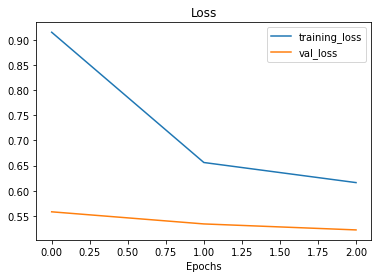

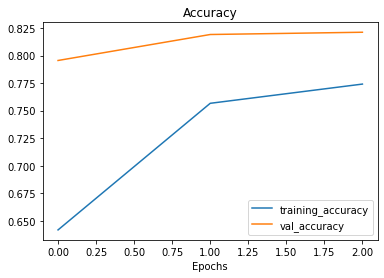

In [ ]:
plot_loss_curves(history_1)

In [ ]:
y_pred = model_1.predict(val_sentences)
y_pred[:5]

array([[7.15788379e-02, 1.87102072e-02, 2.76683422e-05, 9.09682691e-01,
        6.02195939e-07],
       [1.61029791e-04, 5.36129577e-04, 9.43149984e-01, 8.25154493e-05,
        5.60702644e-02],
       [1.80976000e-02, 6.94061294e-02, 4.96866852e-01, 1.07101565e-02,
        4.04919237e-01],
       [1.05586024e-02, 2.63161981e-03, 9.64145541e-01, 1.08094262e-02,
        1.18548675e-02],
       [4.84570162e-04, 4.77657653e-04, 9.78407085e-01, 4.48416889e-04,
        2.01822370e-02]], dtype=float32)

In [ ]:
y_preds = tf.argmax(y_pred, axis=1)
y_preds

<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 1, 0])>

In [ ]:
results_1 = calculate_results(y_true=val_enc,
                              y_pred=y_preds)
results_1

{'accuracy': 0.8006109753388136,
 'f1': 0.7984420450755181,
 'precision': 0.7978602227665815,
 'recall': 0.8006109753388136}

## Model 2
Tfhub pretrained token embedding (USE)

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  trainable=False,
                                  name="universal_sentence_encoder")

In [ ]:
target_sen = random.choice(train_sentences)

print(f"Text: {target_sen}")
print(f"Length: {len(target_sen)}")
print(f"Embedded shape: {tf_hub_embedding([target_sen]).shape}")

Text: chronic release of cortisol can damage hippocampus neurons , leading to impairment of learning and memory .

Length: 108
Embedded shape: (1, 512)


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
embedded = tf_hub_embedding(inputs)
x = layers.Dense(128, activation="relu")(embedded)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_2 = model_2.fit(train_ds,
            epochs=3,
            steps_per_epoch=int(0.1*len(train_ds)),
            validation_data=val_ds,
            validation_steps=int(0.1*len(val_ds)))

Epoch 1/3
562/562 [==============================] - 14s 20ms/step - loss: 0.9203 - accuracy: 0.6492 - val_loss: 0.7843 - val_accuracy: 0.7032
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.7748 - accuracy: 0.6990 - val_loss: 0.7574 - val_accuracy: 0.7127
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7574 - accuracy: 0.7111 - val_loss: 0.7479 - val_accuracy: 0.7140


In [ ]:
model_2.evaluate(val_ds)

5627/5627 [==============================] - 58s 10ms/step - loss: 0.7511 - accuracy: 0.7099


[0.7511259913444519, 0.7099199891090393]

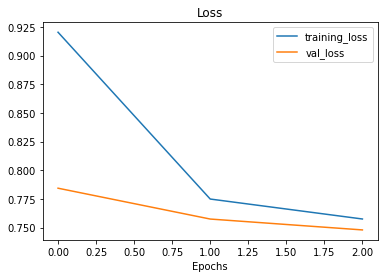

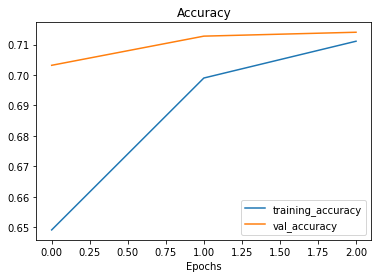

In [ ]:
plot_loss_curves(history_2)

In [ ]:
y_preds = tf.argmax(model_2.predict(val_sentences), axis=1)
y_preds

<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([3, 2, 2, ..., 1, 1, 2])>

In [ ]:
results_2 = calculate_results(y_true=val_enc, y_pred=y_preds)
results_2

{'accuracy': 0.7099200177738281,
 'f1': 0.7077469483478249,
 'precision': 0.7137567404117441,
 'recall': 0.7099200177738281}

## Model 3
Character embedding Conv1D

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars("Hello world")

'H e l l o   w o r l d'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   . \n'

In [ ]:
char_lengths = [len(sentence) for sentence in train_sentences]
mean_char_lengths = np.mean(char_lengths)
mean_char_lengths

150.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   2. ,  140.5,  279. ,  417.5,  556. ,  694.5,  833. ,  971.5,
        1110. , 1248.5, 1387. ]),
 <a list of 10 Patch objects>)

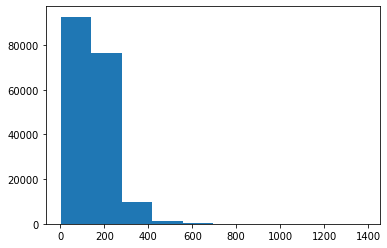

In [ ]:
plt.hist(char_lengths, bins=10)

In [ ]:
output_length = int(np.percentile(char_lengths, 95))
output_length # use the 95th percentile value to cover most words (around 95% data)

291

In [ ]:
# get all keyboard characters for character embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# max tokens will be all the characters in 'alphabet' + OOV + space token
max_char_tokens = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=max_char_tokens,
                                    output_sequence_length=output_length,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vect")
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
f"Num of chars in vocab: {char_vocab}"

"Num of chars in vocab: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']"

In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Text: {random_train_chars}")
print(f"Length: {len(random_train_chars)}")
print(f"Vectorized: {char_vectorizer([random_train_chars])}")
print(f"Vectorized length: {len(char_vectorizer([random_train_chars]))}")

Text: t h e   s t a t u s   o f   h y p e r c o a g u l a b i l i t y   m a y   s u s t a i n   a t   l e a s t   @   d a y s   a f t e r   t o t a l   h i p   r e p l a c e m e n t   . 

Length: 181
Vectorized: [[ 3 13  2  9  3  5  3 16  9  7 17 13 19 14  2  8 11  7  5 18 16 12  5 22
   4 12  4  3 19 15  5 19  9 16  9  3  5  4  6  5  3 12  2  5  9  3 10  5
  19  9  5 17  3  2  8  3  7  3  5 12 13  4 14  8  2 14 12  5 11  2 15  2
   6  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # size of char embedding in pubmed paper
                              mask_zero=True,
                              name="char_embed")

char_embed

In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Text: {random_train_chars}")
print(f"Length: {len(random_train_chars)}")
print(f"Vectorized: {char_vectorizer([random_train_chars])}")
print(f"Vectorized length: {len(char_vectorizer([random_train_chars]))}")
print(f"Embedded: {char_embed(char_vectorizer([random_train_chars]))}")
print(f"Embedded: {char_embed(char_vectorizer([random_train_chars])).shape}")

Text: i n   t h e   p h a s e   i i i   g o - r a i s e   t r i a l   ,   @   p a t i e n t s   w e r e   r a n d o m i z e d   t o   p l a c e b o   w i t h   c r o s s o v e r   t o   g o l i m u m a b   @   m g   a t   w e e k   @   (   n   =   @   )   ,   g o l i m u m a b   @   m g   (   n   =   @   )   ,   o r   g o l i m u m a b   @   m g   (   n   =   @   )   a t   b a s e l i n e   a n d   e v e r y   @   w e e k s   . 

Length: 427
Vectorized: [[ 4  6  3 13  2 14 13  5  9  2  4  4  4 18  7  8  5  4  9  2  3  8  4  5
  12 14  5  3  4  2  6  3  9 20  2  8  2  8  5  6 10  7 15  4 25  2 10  3
   7 14 12  5 11  2 22  7 20  4  3 13 11  8  7  9  9  7 21  2  8  3  7 18
   7 12  4 15 16 15  5 22 15 18  5  3 20  2  2 23  6 18  7 12  4 15 16 15
   5 22 15 18  6  7  8 18  7 12  4 15 16 15  5 22 15 18  6  5  3 22  5  9
   2 12  4  6  2  5  6 10  2 21  2  8 19 20  2  2 23  9  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
tokenized = char_vectorizer(inputs)
embedded = char_embed(tokenized)
x = layers.Conv1D(64, 5, padding="same", activation="relu")(embedded)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 char_vect (TextVectorizatio  (None, 291)              0         
 n)                                                              
                                                                 
 char_embed (Embedding)      (None, 291, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 291, 64)           8064      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
history_3 = model_3.fit(train_ds,
            epochs=3,
            steps_per_epoch=int(0.1*len(train_ds)),
            validation_data=val_ds,
            validation_steps=int(0.1*len(val_ds)))

Epoch 1/3
562/562 [==============================] - 5s 8ms/step - loss: 1.4710 - accuracy: 0.3582 - val_loss: 1.4301 - val_accuracy: 0.4376
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.3734 - accuracy: 0.4228 - val_loss: 1.3414 - val_accuracy: 0.4401
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 1.3403 - accuracy: 0.4360 - val_loss: 1.3398 - val_accuracy: 0.4387


In [ ]:
model_3.evaluate(val_ds)

5627/5627 [==============================] - 18s 3ms/step - loss: 1.3376 - accuracy: 0.4337


[1.3376233577728271, 0.43372583389282227]

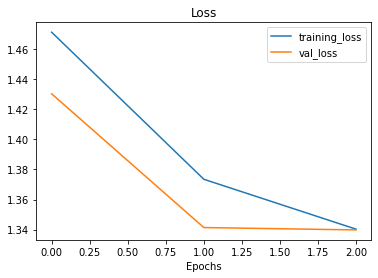

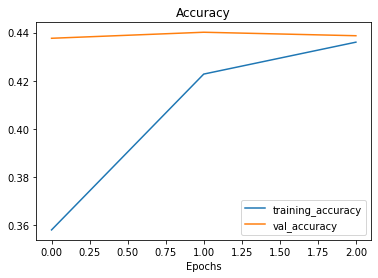

In [ ]:
plot_loss_curves(history_3)

In [ ]:
y_preds = tf.argmax(model_3.predict(val_sentences), axis=1)
results_3 = calculate_results(y_true=val_enc, y_pred=y_preds)
results_3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.4337258387025106,
 'f1': 0.3390176966468751,
 'precision': 0.40719868865755937,
 'recall': 0.4337258387025106}

## Model 4
Using token and character embeddings

In [ ]:
# token level embedding
token_inputs = layers.Input(shape=[], dtype=tf.string, name="input_layer")
token_embedding = tf_hub_embedding(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs)

In [ ]:
# char level embedding
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layers_2")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_inputs, char_outputs)

In [ ]:
# Concatenate token and char level embeddings
concat_model = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                             char_model.output])
concat_model

<KerasTensor: shape=(None, 176) dtype=float32 (created by layer 'token_char_hybrid')>

In [ ]:
# combined dropout
combined_dropout = layers.Dropout(0.5)(concat_model)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer)

model_4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layers_2 (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 input_layer (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vect (TextVectorization)  (None, 291)          0           ['input_layers_2[0][0]']         
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_layer[0][0]']            
 rasLayer)                                                                                  

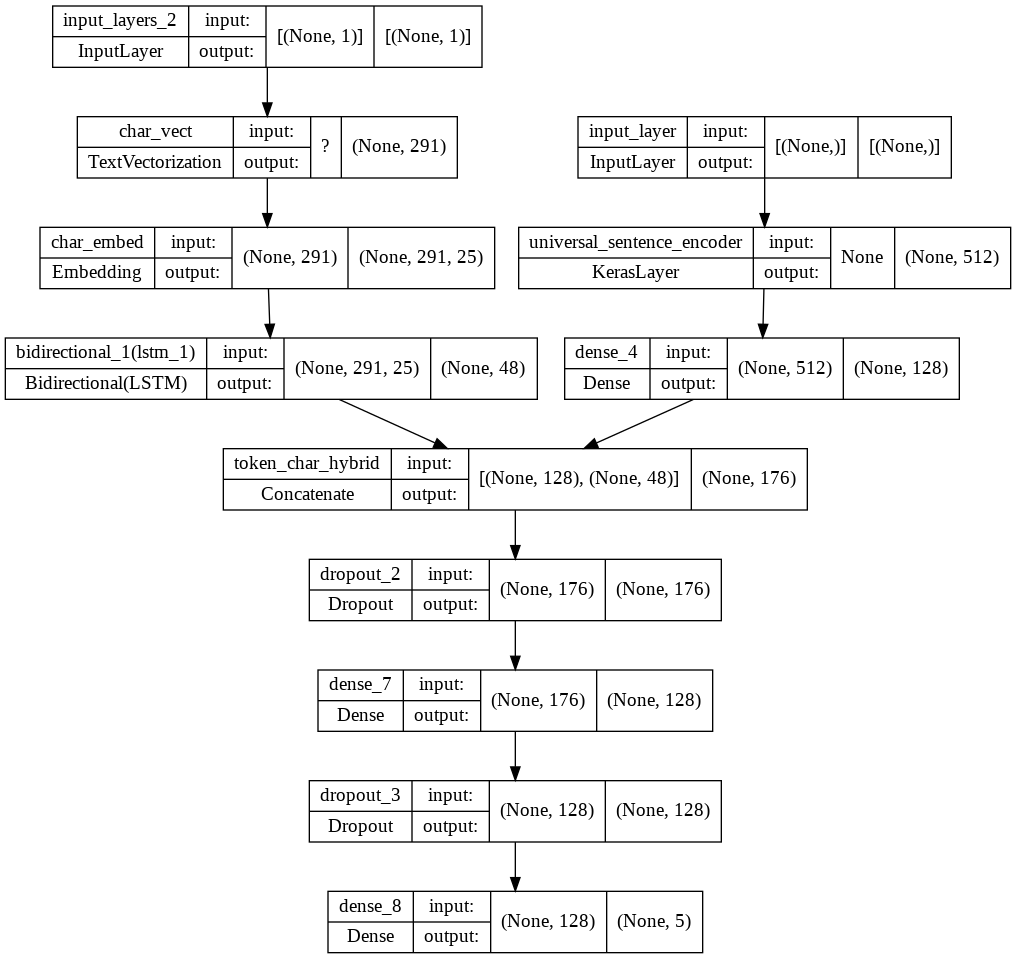

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Creating data sets
train_ct_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_ct_labels = tf.data.Dataset.from_tensor_slices(train_ohe)
train_ctds = tf.data.Dataset.zip((train_ct_data, train_ct_labels))
train_ctds = train_ctds.batch(32).prefetch(tf.data.AUTOTUNE)

val_ct_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_ct_labels = tf.data.Dataset.from_tensor_slices(val_ohe)
val_ctds = tf.data.Dataset.zip((val_ct_data, val_ct_labels))
val_ctds = val_ctds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ctds, val_ctds

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_4 = model_4.fit(train_ctds,
                        steps_per_epoch=int(0.1*len(train_ctds)),
                        epochs=3,
                        validation_data=val_ctds,
                        validation_steps=int(0.1*len(val_ctds)))

Epoch 1/3
562/562 [==============================] - 46s 69ms/step - loss: 0.8749 - accuracy: 0.6641 - val_loss: 0.7001 - val_accuracy: 0.7348
Epoch 2/3
562/562 [==============================] - 36s 63ms/step - loss: 0.7562 - accuracy: 0.7117 - val_loss: 0.6847 - val_accuracy: 0.7410
Epoch 3/3
562/562 [==============================] - 33s 59ms/step - loss: 0.7458 - accuracy: 0.7160 - val_loss: 0.6751 - val_accuracy: 0.7447


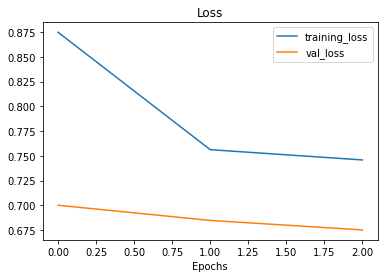

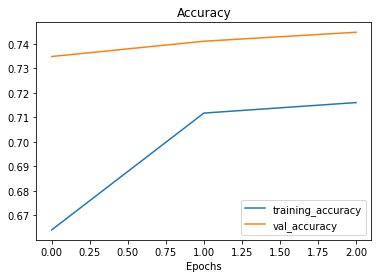

In [ ]:
plot_loss_curves(history_4)

In [ ]:
model_4.evaluate(val_ctds)

5627/5627 [==============================] - 124s 22ms/step - loss: 0.6798 - accuracy: 0.7409


[0.6797579526901245, 0.7408909201622009]

In [ ]:
y_preds = tf.argmax(model_4.predict(val_ctds), axis=1)
results_4 = calculate_results(y_true=val_enc, y_pred=y_preds)
results_4                                                                                                                    

{'accuracy': 0.7408909131304154,
 'f1': 0.7379835066353289,
 'precision': 0.7402334689268555,
 'recall': 0.7408909131304154}

# Model 5
USE token embeddings + character embeddings + positional embeddings

In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

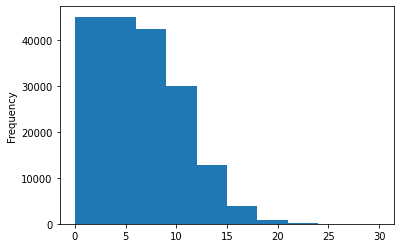

In [ ]:
train_df["line_number"].plot.hist() # majority lines have positions <= 15

In [ ]:
# preprocessing line number as a variable
train_ln_ohe = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_ln_ohe = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_ln_ohe = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_ln_ohe.shape

TensorShape([180040, 15])

In [ ]:
train_ln_ohe[:20]

<tf.Tensor: shape=(20, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
train_df["total_lines"].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

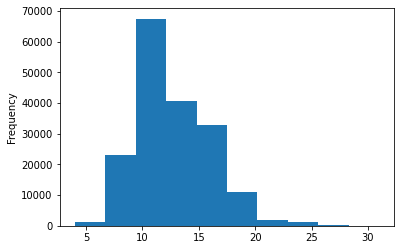

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
np.percentile(train_df["total_lines"], 98) # covers 98% of samples

21.0

In [ ]:
train_tl_ohe = tf.one_hot(train_df["total_lines"].to_numpy(), depth=21)
val_tl_ohe = tf.one_hot(val_df["total_lines"].to_numpy(), depth=21)
test_tl_ohe = tf.one_hot(test_df["total_lines"].to_numpy(), depth=21)

train_tl_ohe.shape

TensorShape([180040, 21])

In [ ]:
train_tl_ohe[:15]

<tf.Tensor: shape=(15, 21), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
# Model building

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bilstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bilstm)

# 3. Line number inputs
ln_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="ln_input")
x = layers.Dense(32, activation="relu")(ln_inputs)
ln_model = tf.keras.Model(inputs=ln_inputs,
                          outputs=x)

# 4. Total lines inputs
tl_inputs = layers.Input(shape=(21,), dtype=tf.int32, name="tl_input")
y = layers.Dense(32, activation="relu")(tl_inputs)
tl_model = tf.keras.Model(inputs=tl_inputs,
                          outputs=y)

# 5. Combine token and char embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([ln_model.output,
                                                                tl_model.output,
                                                                z])

# 7. Output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

model_5 = tf.keras.Model(inputs=[ln_model.input,
                                 tl_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

model_5.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 char_vect (TextVectorization)  (None, 291)          0           ['char_inputs[0][0]']            
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_embed (Embedding)         (None, 291, 25)      700         ['char_vect[3][0]']              
                                                                                           

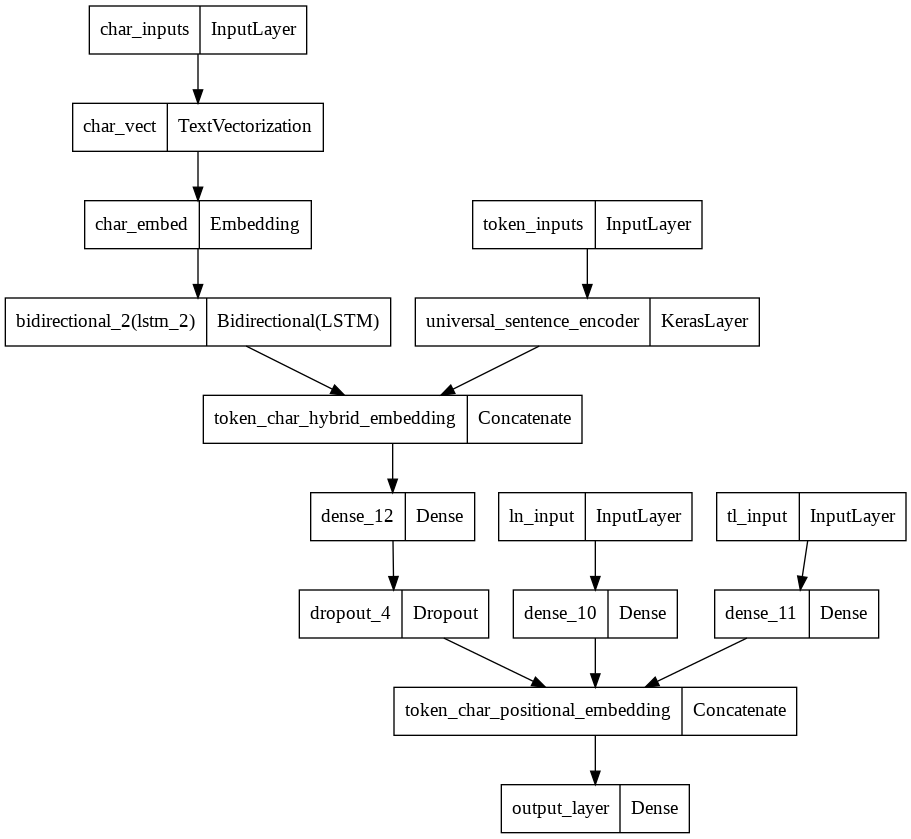

In [ ]:
plot_model(model_5)

In [ ]:
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_pct_data = tf.data.Dataset.from_tensor_slices((train_ln_ohe,
                                                     train_tl_ohe,
                                                     train_sentences,
                                                     train_chars))
train_pct_labels = tf.data.Dataset.from_tensor_slices(train_ohe)
train_pct_ds = tf.data.Dataset.zip((train_pct_data, train_pct_labels))
train_pct_ds = train_pct_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_pct_data = tf.data.Dataset.from_tensor_slices((val_ln_ohe,
                                                  val_tl_ohe,
                                                  val_sentences,
                                                  val_chars))
val_pct_labels = tf.data.Dataset.from_tensor_slices(val_ohe)
val_pct_ds = tf.data.Dataset.zip((val_pct_data, val_pct_labels))
val_pct_ds = val_pct_ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_pct_ds

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_5 = model_5.fit(train_pct_ds,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_pct_ds)),
                        validation_data=val_pct_ds,
                        validation_steps=int(0.1*len(val_pct_ds)))

Epoch 1/3
562/562 [==============================] - 84s 123ms/step - loss: 0.7726 - accuracy: 0.7125 - val_loss: 0.5524 - val_accuracy: 0.7921
Epoch 2/3
562/562 [==============================] - 63s 112ms/step - loss: 0.5232 - accuracy: 0.8002 - val_loss: 0.4965 - val_accuracy: 0.8074
Epoch 3/3
562/562 [==============================] - 58s 103ms/step - loss: 0.4896 - accuracy: 0.8081 - val_loss: 0.4773 - val_accuracy: 0.8139


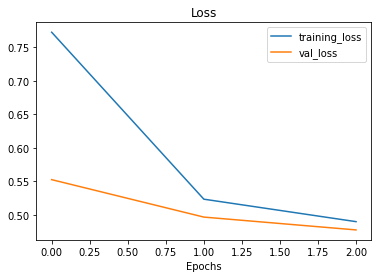

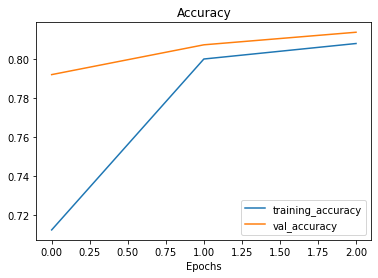

In [ ]:
plot_loss_curves(history_5)

In [ ]:
model_5.evaluate(val_pct_ds)

5627/5627 [==============================] - 167s 30ms/step - loss: 0.4722 - accuracy: 0.8180


[0.4722217619419098, 0.8179960250854492]

In [ ]:
y_preds = tf.argmax(model_5.predict(val_pct_ds), axis=1)
results_5 = calculate_results(y_true=val_enc,
                              y_pred=y_preds)
results_5

{'accuracy': 0.8179960008886914,
 'f1': 0.8176712130793842,
 'precision': 0.8179189745853647,
 'recall': 0.8179960008886914}

## Results Comparison

In [ ]:
results_df = pd.DataFrame({
    "baseline": model_0_results,
    "token_emb_conv1d": results_1,
    "use_pretrained": results_2,
    "char_emb_conv1d": results_3,
    "hybrid_embed": results_4,
    "tribrid_embed": results_5
}).T
results_df

,accuracy,precision,recall,f1
baseline,0.751683,0.755612,0.751683,0.734085
token_emb_conv1d,0.800611,0.797860,0.800611,0.798442
use_pretrained,0.709920,0.713757,0.709920,0.707747
char_emb_conv1d,0.433726,0.407199,0.433726,0.339018
hybrid_embed,0.740891,0.740233,0.740891,0.737984
tribrid_embed,0.817996,0.817919,0.817996,0.817671


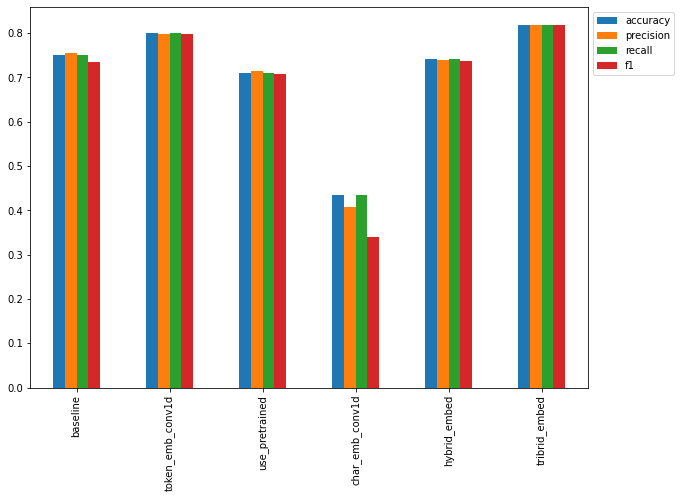

In [ ]:
results_df.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

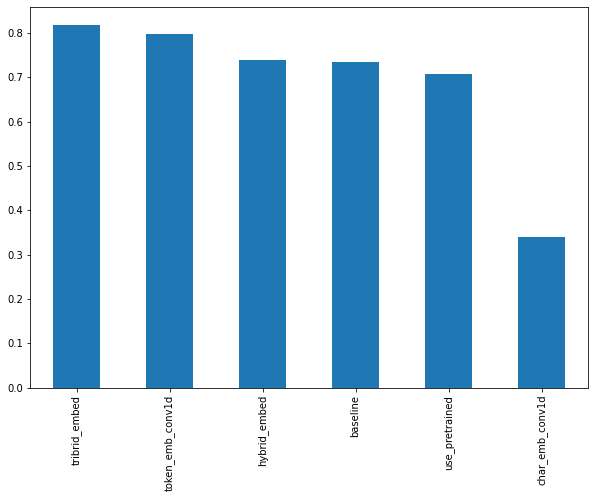

In [ ]:
results_df.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

In [ ]:
test_pct_data = tf.data.Dataset.from_tensor_slices((test_ln_ohe,
                                                    test_tl_ohe,
                                                    test_sentences,
                                                    test_chars))
test_pct_labels = tf.data.Dataset.from_tensor_slices(test_ohe)
test_pct_ds = tf.data.Dataset.zip((test_pct_data, test_pct_labels))
test_pct_ds = test_pct_ds.batch(32).prefetch(tf.data.AUTOTUNE)

test_pct_ds

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
y_preds = tf.argmax(axis=1, input=model_5.predict(test_pct_ds))
test_results = calculate_results(y_true=test_enc,
                                 y_pred=y_preds)
test_results

{'accuracy': 0.8179960008886914,
 'f1': 0.8176712130793842,
 'precision': 0.8179189745853647,
 'recall': 0.8179960008886914}

In [ ]:
test_preds = [label_encoder.classes_[pred] for pred in y_preds]
test_preds[:10]

['OBJECTIVE',
 'METHODS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [ ]:
test_df

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12
...,...,...,...,...
180035,7,RESULTS,for the absolute change in percent atheroma vo...,12
180036,8,RESULTS,"for pav , a significantly greater percentage o...",12
180037,9,RESULTS,both strategies had acceptable side effect pro...,12
180038,10,CONCLUSIONS,"compared with standard statin monotherapy , th...",12


In [ ]:
test_df["prediction"] = test_preds
test_df["probability"] = tf.reduce_max(model_5.predict(test_pct_ds), axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(10)

,line_number,target,text,total_lines,prediction,probability,correct
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12,OBJECTIVE,0.930764,True
1,1,METHODS,a total of @ patients with primary knee oa wer...,12,METHODS,0.824942,True
2,2,METHODS,outcome measures included pain reduction and i...,12,OBJECTIVE,0.431503,False
3,3,METHODS,pain was assessed using the visual analog pain...,12,METHODS,0.969633,True
4,4,METHODS,secondary outcome measures included the wester...,12,METHODS,0.952573,True
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",12,METHODS,0.716074,True
6,6,RESULTS,there was a clinically relevant reduction in t...,12,RESULTS,0.513952,True
7,7,RESULTS,the mean difference between treatment arms ( @...,12,RESULTS,0.997064,True
8,8,RESULTS,"further , there was a clinically relevant redu...",12,RESULTS,0.908526,True
9,9,RESULTS,these differences remained significant at @ we...,12,RESULTS,0.786520,True


In [ ]:
top100_wrong = test_df[test_df["correct"] == False].sort_values("probability", ascending=False)
top100_wrong

,line_number,target,text,total_lines,prediction,probability,correct
62258,7,METHODS,motor block was significantly higher in group ...,11,RESULTS,0.999687,False
92563,8,METHODS,the ratios of adverse events were @ % and @ % ...,10,RESULTS,0.999263,False
48234,8,METHODS,mean pdc was higher in the int group ( @ vs @ ...,14,RESULTS,0.999255,False
132564,9,METHODS,"at the end of the @th week , vm was increased ...",19,RESULTS,0.999227,False
118143,13,METHODS,"at distances of @-@ @ and @-@ @ miles , twice ...",17,RESULTS,0.998847,False
...,...,...,...,...,...,...,...
147994,2,OBJECTIVE,since patients hospitalized with pneumonia mig...,9,METHODS,0.245508,False
135349,3,BACKGROUND,we hypothesized that parental mvp and ndms inc...,11,RESULTS,0.240003,False
14214,3,RESULTS,operative time was decreased with the use of a...,7,BACKGROUND,0.237764,False
39732,2,METHODS,"in study @ , @ respondents listened to a healt...",9,BACKGROUND,0.233875,False
